In [61]:
legend_utils_path = '/global/homes/f/fnafis/LEGEND/legend'
import sys
if legend_utils_path not in sys.path:
    sys.path.append(legend_utils_path)
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import pygama.math.histogram as pgh
import legend_utils as lu
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
plt.style.use('~/KrSTC/data/physrev.mpl')

def get_peak_and_bkg_count(h, b):
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    peak_count = fit_params['area']
    return peak_count, np.sum(h) - peak_count, (np.sum(h) - peak_count)/(b[-1]-b[0])


def get_param_map(df, param='bkg_density', id='mage_id', round_to=None):
    map = pd.DataFrame()
    for i, val in zip(df[id], df[param]):
        ii = str(i)
        col = int(ii[3:5])
        row = int(ii[5:7])
        if round_to is None:
            map.at[row, col] = val
        else:
            map.at[row, col] = round(val, round_to)
    # sort the columns
    map = map.reindex(sorted(map.columns), axis=1)
    # add 'String ' to the columns
    map.columns = ['String ' + str(col) for col in map.columns]
    # sort the rows
    map = map.sort_index(ascending=True)
    return map


In [1]:
peaks = {
    '1987':
    {
        'name': '1987',
        'type': 'DEP',
        'energy':1987.0,
        'sidebands':[[1975,1983],[1991,2000]],
        'peak_range': [1983,1991]
    },
    '3009':
    {
        'name': '3009',
        'type': 'FEP',
        'energy':3009.6,
        'sidebands':[[2995,3000],[3020,3025]],
        'peak_range': [3005,3015]
    }
}


# Load sim energy and dets

In [9]:
# Load full Co sim first
# If you include all the filenames on all position, it will cover full array automatically
evt_filenames_full_Co = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_vancouver.txt'
df_full_Co = pd.DataFrame()
primaries_full_Co = 0
with open(evt_filenames_full_Co) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries_full_Co += len(dets)
        dets = np.concatenate(dets)
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df_full_Co = pd.concat([df_full_Co, d], ignore_index=True)
   
print('primaries full Co', primaries_full_Co)
df_full_Co['energy'] = df_full_Co['energy'].apply(lambda x: x*1000)
df_full_Co

primaries full Co 119994453


,mage_id,energy
0,1010704,144.095972
1,1011102,700.127400
2,1010906,401.827494
3,1010805,434.088314
4,1010806,603.299438
...,...,...
153941950,1011004,162.523602
153941951,1010705,305.416521
153941952,1011102,183.354690
153941953,1010703,3.997480


In [32]:
cm = lu.get_count_map(df_full_Co)
cm/cm.sum().sum()*100


,string 1,string 2,string 3,string 4,string 5,string 7,string 8,string 9,string 10,string 11
1,0.086375,0.029329,0.033856,0.036876,0.112036,0.223910,0.065406,0.051901,0.056968,0.033103
2,0.160191,0.114914,0.047869,0.066678,0.515621,0.815990,0.093521,0.077529,0.086578,0.060345
3,0.326056,0.204286,0.091556,0.091676,1.858413,5.028675,0.836152,0.147019,0.130365,0.069888
4,0.391383,0.379021,0.136654,0.127517,2.496790,29.950102,2.972710,0.283674,0.208849,0.194470
5,0.367628,0.454981,0.233054,0.210404,2.347723,7.580770,9.295716,0.756597,0.303683,0.297773
6,0.249540,0.351525,0.266876,0.261861,NaN,1.199628,8.413648,1.517645,0.489483,0.411608
7,0.166445,0.161970,0.276877,0.348102,NaN,0.237252,1.716962,2.228453,0.617864,0.359637
8,0.075515,0.079635,0.197694,0.528692,NaN,NaN,0.525125,1.593710,0.594470,0.285625
9,0.036750,0.041192,0.147545,0.480462,NaN,NaN,0.197508,0.831143,1.411014,0.187992
10,NaN,NaN,NaN,0.288659,NaN,NaN,0.054880,0.404204,0.827652,0.127553


0
{'popt': array([ 1.03412630e+01,  1.98747996e+03,  1.07685168e+01,  1.34859247e+05,
       -1.35724644e+02,  3.41464171e-02]), 'perr': array([9.70722056e+01, 5.29019240e-01, 2.94581186e+01, 7.16819550e+05,
       7.21432259e+02, 1.81494083e-01]), 'pcov': array([[ 9.42301311e+03,  6.87971176e-01,  2.85795136e+03,
         6.95603289e+07, -7.00079548e+04,  1.76122285e+01],
       [ 6.87971176e-01,  2.79861356e-01,  2.03298648e-01,
         5.22595600e+03, -5.24264289e+00,  1.31465896e-03],
       [ 2.85795136e+03,  2.03298648e-01,  8.67780753e+02,
         2.10794289e+07, -2.12150794e+04,  5.33717680e+00],
       [ 6.95603289e+07,  5.22595600e+03,  2.10794289e+07,
         5.13830267e+11, -5.17136746e+08,  1.30098506e+05],
       [-7.00079548e+04, -5.24264289e+00, -2.12150794e+04,
        -5.17136746e+08,  5.20464504e+05, -1.30935686e+02],
       [ 1.76122285e+01,  1.31465896e-03,  5.33717680e+00,
         1.30098506e+05, -1.30935686e+02,  3.29401022e-02]]), 'fwhm': 25.359856946488993,

3.333487423789498e-08

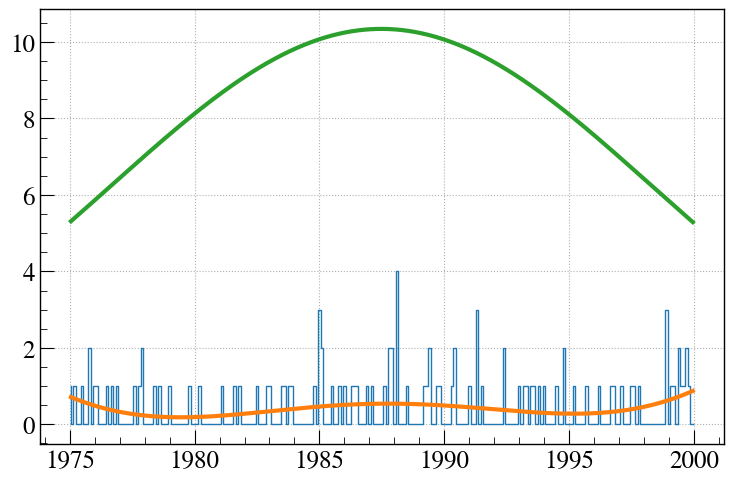

In [59]:
d = df_full_Co[df_full_Co['mage_id'] == 1010707]
peak = peaks['1987']
h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
b_mids = (b[1:] + b[:-1])/2
plt.plot(b_mids, h, ds='steps', lw=1)
fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=plt.gca())
peak_count = fit_params['area'] if ((fit_params['popt'][1] > peak['peak_range'][0]) & (fit_params['popt'][1] < peak['peak_range'][1] & (fit_params['fwhm']<3.0))) else 0
print(peak_count)
print(fit_params)
(np.sum(h) - peak_count)/(b[-1]-b[0])/primaries_full_Co


In [67]:
geds = df_full_Co['mage_id'].unique()
def get_full_Co_hists_df(full_Co_df, geds, peak):
    d = full_Co_df[full_Co_df['mage_id'].isin(geds)]
    h,b,v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    return (h,b,v)
full_Co_hists = [get_full_Co_hists_df(df_full_Co, [ged], peaks['1987']) for ged in geds]
full_Co_hists_df = pd.DataFrame({'mage_id': geds, 'hbv': full_Co_hists})
# full_Co_hists_map = get_param_map(full_Co_hists_df, param='hbv', id='mage_id')
# full_Co_hists_map


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
fig, ax = plt.subplots(14,11, figsize=(70,55), sharex=True, sharey=True)
for 

In [62]:
# get bkg_density df
geds = df_full_Co['mage_id'].unique()
def get_bkg_per_keV_per_primary(full_Co_df, full_Co_primaries, geds, peak):
    # print('geds', geds)
    d = full_Co_df[full_Co_df['mage_id'].isin(geds)]
    h,b,v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    if fit_params['area'] is None:
        peak_count = 0
    else:
        peak_count = fit_params['area'] if ((fit_params['popt'][1] > peak['peak_range'][0]) & (fit_params['popt'][1] < peak['peak_range'][1]) & (fit_params['area']>0) & (fit_params['fwhm']<4.0)) else 0
    return (np.sum(h) - peak_count)/(b[-1]-b[0])/full_Co_primaries
bkg_density = []
for ged in geds:
    bkg_density.append(get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, [ged], peaks['1987']))
bkg_density_df = pd.DataFrame({'mage_id': geds, 'bkg_density': bkg_density})
print(bkg_density_df)
bkg_density_map = get_param_map(bkg_density_df, param='bkg_density', id='mage_id')
(bkg_density_map*1e6).round(2)

fit failed
fit failed
fit failed
fit failed
fit failed
fit failed
fit failed
fit failed
fit failed


/opt/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/global/homes/f/fnafis/LEGEND/legend/legend_utils.py:381: RuntimeWarning: invalid value encountered in scalar add
  area_err = area*np.sqrt((A_err/A)**2 + (sigma_err/sigma)**2 + 2*cov_A_sigma/(A*sigma)) # https://www.ucl.ac.uk/~ucfbpve/geotopes/indexch10.html


fit failed
fit failed
fit failed
fit failed
fit failed
     mage_id   bkg_density
0    1010704  1.893323e-05
1    1011102  1.800083e-08
2    1010906  3.630168e-07
3    1010805  2.766531e-06
4    1010806  2.526783e-06
..       ...           ...
96   1010109  1.366730e-08
97   1010901  1.366730e-08
98   1010209  1.066716e-08
99   1011101  9.000416e-09
100  1010402  1.666744e-08

[101 rows x 2 columns]


,String 1,String 2,String 3,String 4,String 5,String 7,String 8,String 9,String 10,String 11
1,0.03,0.01,0.01,0.01,0.03,0.04,0.01,0.01,0.02,0.01
2,0.05,0.04,0.02,0.02,0.15,0.17,0.01,0.02,0.03,0.02
3,0.09,0.05,0.03,0.03,0.53,1.47,0.19,0.04,0.03,0.02
4,0.11,0.11,0.03,0.03,0.64,18.93,0.79,0.07,0.05,0.05
5,0.09,0.13,0.06,0.05,0.60,2.33,2.77,0.18,0.07,0.07
6,0.07,0.08,0.06,0.05,NaN,0.30,2.53,0.36,0.12,0.09
7,0.05,0.05,0.05,0.07,NaN,0.03,0.45,0.53,0.13,0.07
8,0.02,0.02,0.05,0.14,NaN,NaN,0.12,0.37,0.13,0.05
9,0.01,0.01,0.03,0.12,NaN,NaN,0.05,0.21,0.34,0.04
10,NaN,NaN,NaN,0.07,NaN,NaN,0.01,0.10,0.23,0.03


In [63]:
# Now load only gamma simulation data
evt_filenames_gamma = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_3009_sis2_neg376mm_old.txt'
df_gamma = pd.DataFrame()
primaries_gamma = 0
with open(evt_filenames_gamma) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries_gamma += len(dets)
        dets = np.concatenate(dets)
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df_gamma = pd.concat([df_gamma, d], ignore_index=True)

print('primaries gamma', primaries_gamma)
df_gamma['energy'] = df_gamma['energy'].apply(lambda x: x*1000)
df_gamma


primaries gamma 19997393


,mage_id,energy
0,1010810,240.183870
1,1010913,211.003397
2,1010810,3008.419157
3,1010912,121.526680
4,1010206,2514.453719
...,...,...
6903669,1010810,562.630703
6903670,1010912,2499.398248
6903671,1010912,1878.805051
6903672,1010810,52.246931


In [ ]:
# get gamma peak counts
geds = df_gamma['mage_id'].unique()
def get_gamma_peak_counts(df, primaries, geds, peak):
    # print('geds', geds)
    d = df[df['mage_id'].isin(geds)]
    h,b,v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    if fit_params['area'] is None:
        peak_count = 0
    else:
        peak_count = fit_params['area'] if ((fit_params['popt'][1] > peak['peak_range'][0]) & (fit_params['popt'][1] < peak['peak_range'][1]) & (fit_params['area']>0) & (fit_params['fwhm']<4.0)) else 0
    return (np.sum(h) - peak_count)/(b[-1]-b[0])/full_Co_primaries
bkg_density = []
for ged in geds:
    bkg_density.append(get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, [ged], peaks['1987']))
bkg_density_df = pd.DataFrame({'mage_id': geds, 'bkg_density': bkg_density})
print(bkg_density_df)
bkg_density_map = get_param_map(bkg_density_df, param='bkg_density', id='mage_id')
(bkg_density_map*1e6).round(2)

### Sim from vancouver results

In [3]:
evt_filenames_vancouver = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_vancouver.txt'
df_vanc = pd.DataFrame()
primaries_vanc = 0
with open(evt_filenames_vancouver) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries_vanc += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df_vanc = pd.concat([df_vanc, d], ignore_index=True)
   
print('primaries_vanc', primaries_vanc)
df_vanc['energy'] = df_vanc['energy'].apply(lambda x: x*1000)
df_vanc

primaries_vanc 119994453


,mage_id,energy
0,1010704,144.095972
1,1011102,700.127400
2,1010906,401.827494
3,1010805,434.088314
4,1010806,603.299438
...,...,...
153941950,1011004,162.523602
153941951,1010705,305.416521
153941952,1011102,183.354690
153941953,1010703,3.997480


In [8]:
evt_filenames = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_3009_sis2_neg376mm_old.txt'
df = pd.DataFrame()
primaries = 0
with open(evt_filenames) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        # print(evt_filename)
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df = pd.concat([df, d], ignore_index=True)
   
print(primaries)
df['energy'] = df['energy'].apply(lambda x: x*1000)
df

19997393


,mage_id,energy
0,1010810,240.183870
1,1010913,211.003397
2,1010810,3008.419157
3,1010912,121.526680
4,1010206,2514.453719
...,...,...
6903669,1010810,562.630703
6903670,1010912,2499.398248
6903671,1010912,1878.805051
6903672,1010810,52.246931


In [3]:
def get_scaled_Co_primaries(full_Co_primaries, full_Co_energies, gamma_energies, peak, axis=None):
    h,b,v = pgh.get_hist(full_Co_energies, range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    # plt.figure()
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=axis)
    full_Co_peak_count = fit_params['area']

    h,b,v = pgh.get_hist(gamma_energies, range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    # plt.figure()
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=axis)
    gamma_peak_count = fit_params['area']

    return full_Co_primaries * gamma_peak_count/full_Co_peak_count


scaled_Co_primaries = get_scaled_Co_primaries(primaries_vanc, df_vanc['energy'], df['energy'], dep_peaks['1987'], axis=plt.gca())
print('gamma_scaled_primaries', scaled_Co_primaries/1e6, 'M')


NameError: name 'primaries_vanc' is not defined

In [6]:
def get_bkg_per_keV_per_primary(full_Co_df, full_Co_primaries, geds, peak):
    d = full_Co_df[full_Co_df['mage_id'].isin(geds)]
    h,b,v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.1)
    b_mids = (b[1:] + b[:-1])/2
    fit_params = lu.fit_peak_binned_extra_basic(b_mids, h)
    peak_count = fit_params['area']
    return (np.sum(h) - peak_count)/(b[-1]-b[0])/full_Co_primaries
bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_vanc, primaries_vanc, dets_to_use, dep_peaks['1987'])
print('bkg_per_keV_per_primary_full_Co', bkg_per_keV_per_primary_full_Co)

bkg_per_keV_per_primary_full_Co 1.8933232244430938e-05


bkg_per_keV_per_primary_full_Co 1.8933232244430938e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 5.011644827456197e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 9.202359812710166e-06


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


bkg_per_keV_per_primary_full_Co 2.8928226403597354e-08


Text(0.5, 1.0, '3009 in [1010809]')

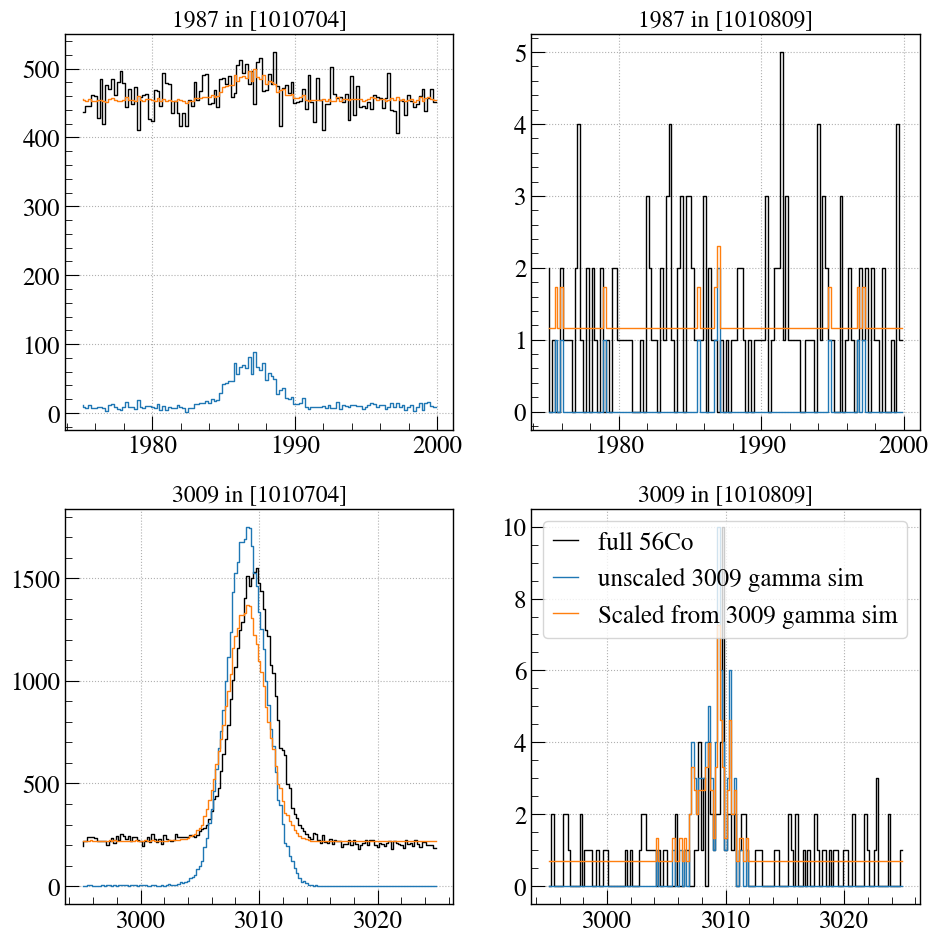

In [7]:


def compare_one_gamma_sim(df_full_Co, primaries_full_Co, df_one_gamma, peak, dets_to_use, axis=None):
    bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, dets_to_use, peak)
    print('bkg_per_keV_per_primary_full_Co', bkg_per_keV_per_primary_full_Co)

    d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    axis.plot(b_mids, h, ds='steps', c='k', lw=1, label='full 56Co')
    # fit_params = lu.fit_peak_binned_extra_basic(b_mids, h, axis=plt.gca(), lw=1)

    d = df_one_gamma[df_one_gamma['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    axis.plot(b_mids, h, ds='steps', c='tab:blue', lw=1, label='unscaled 3009 gamma sim')
    scaled_Co_primaries = get_scaled_Co_primaries(primaries_full_Co, df_full_Co['energy'], df_one_gamma['energy'], peak, axis=None)
    left_bkg = np.sum(h[0:np.argmax(b_mids>peak['sidebands'][0][1])])
    # print('left_bkg', left_bkg)
    total_bkg = left_bkg*(b[-1]-b[0])/(peak['sidebands'][0][1]-peak['sidebands'][0][0])
    # print('total_bkg', total_bkg)
    h = h-total_bkg/len(h)
    h = h*primaries_full_Co/scaled_Co_primaries

    new_bkg = bkg_per_keV_per_primary_full_Co*primaries_vanc*(b[-1]-b[0])
    h = h+new_bkg/len(h)
    axis.plot(b_mids, h, ds='steps', c='tab:orange', lw=1, label='Scaled from 3009 gamma sim')

    plt.legend()
    # plt.ylim(400,500)


fig, ax = plt.subplots(2,2, figsize=(10,10))


peak = dep_peaks['1987']
dets_to_use = [1010704]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[0,0])
ax[0,0].set_title('1987 in '+str(dets_to_use))
dets_to_use = [1010809]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[0,1])
ax[0,1].set_title('1987 in '+str(dets_to_use))

peak = fep_peaks['3009']
dets_to_use = [1010704]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[1,0])
ax[1,0].set_title('3009 in '+str(dets_to_use))
dets_to_use = [1010809]
compare_one_gamma_sim(df_vanc, primaries_vanc, df, peak, dets_to_use, axis=ax[1,1])
ax[1,1].set_title('3009 in '+str(dets_to_use))


27
(33.01571747234828, 82.98428252765171, 2.766142750921724)
93
(-7.0917524621722405, 156.09175246217225, 6.2436700984868905)
peak_count_vanc 33.01571747234828


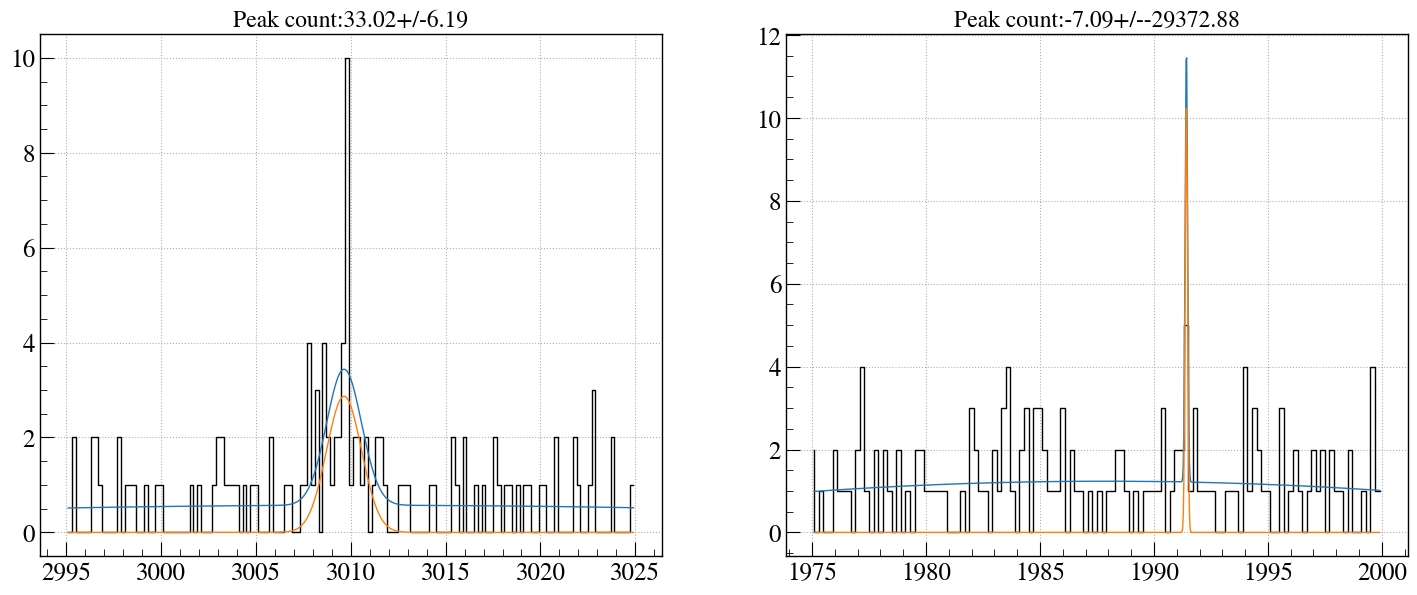

In [8]:
peak = dep_peaks['1987']
peak = fep_peaks['3009']
fig, ax = plt.subplots(1,2, figsize=(16,6))
bkg_per_kev_vancouver = 0 # bkg/keV
for i,peak in enumerate([fep_peaks['3009'], dep_peaks['1987']]):
    d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
    hv, bv, vv = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    bv_mids = (bv[1:] + bv[:-1])/2
    ax[i].plot(bv_mids, hv, ds='steps', lw=1, color='k')
    # get sum of hv where 1960<bv<1975

    left_bkg = np.sum(hv[np.where((bv>peak['sidebands'][0][0]) & (bv<peak['sidebands'][0][1]))])
    right_bkg = np.sum(hv[np.where((bv>peak['sidebands'][1][0]) & (bv<peak['sidebands'][1][1]))])
    bkg_vanc = left_bkg + right_bkg
    print(bkg_vanc)
    print(get_peak_and_bkg_count(hv, bv))

    fit_results = lu.fit_peak_binned_extra_basic(bv_mids, hv, axis=ax[i], lw=1)
    ax[i].set_title('Peak count:'+ str(round(fit_results['area'],2))+'+/-'+str(round(fit_results['area_err'],2)))

    if i==0:
        peak_count_3009_vanc = fit_results['area']
print('peak_count_vanc', peak_count_3009_vanc)

In [9]:
evt_filenames = '/global/homes/f/fnafis/LEGEND/legend/sims/evt_filenames_3009_sis2_neg376mm.txt'
df = pd.DataFrame()
primaries = 0
with open(evt_filenames) as f:
    evt_filenames = f.read().splitlines()
    for evt_filename in evt_filenames:
        print(evt_filename)
        ff = ur.open(evt_filename)
        # print(evt_filename, 'opened')
        dets = ff['simTree/mage_id'].array(library='np')
        primaries += len(dets)
        dets = np.concatenate(dets)
        
        energies = ff['simTree/energy'].array(library='np')
        energies = np.concatenate(energies)
        d = pd.DataFrame({'mage_id': dets, 'energy': energies})
        df = pd.concat([df, d], ignore_index=True)
   
print(primaries)
df['energy'] = df['energy'].apply(lambda x: x*1000)
df

/global/cfs/cdirs/m2676/users/nfuad/gamma_3009_sim/sis2_neg376mm_21183230_evt.root


ValueError: need at least one array to concatenate

New one FEP sim

(2463.9250726643963, 76.07492733560366)
8
(82.14499051274512, 192.85500948725488)
114
peak_count_new 2463.9250726643963


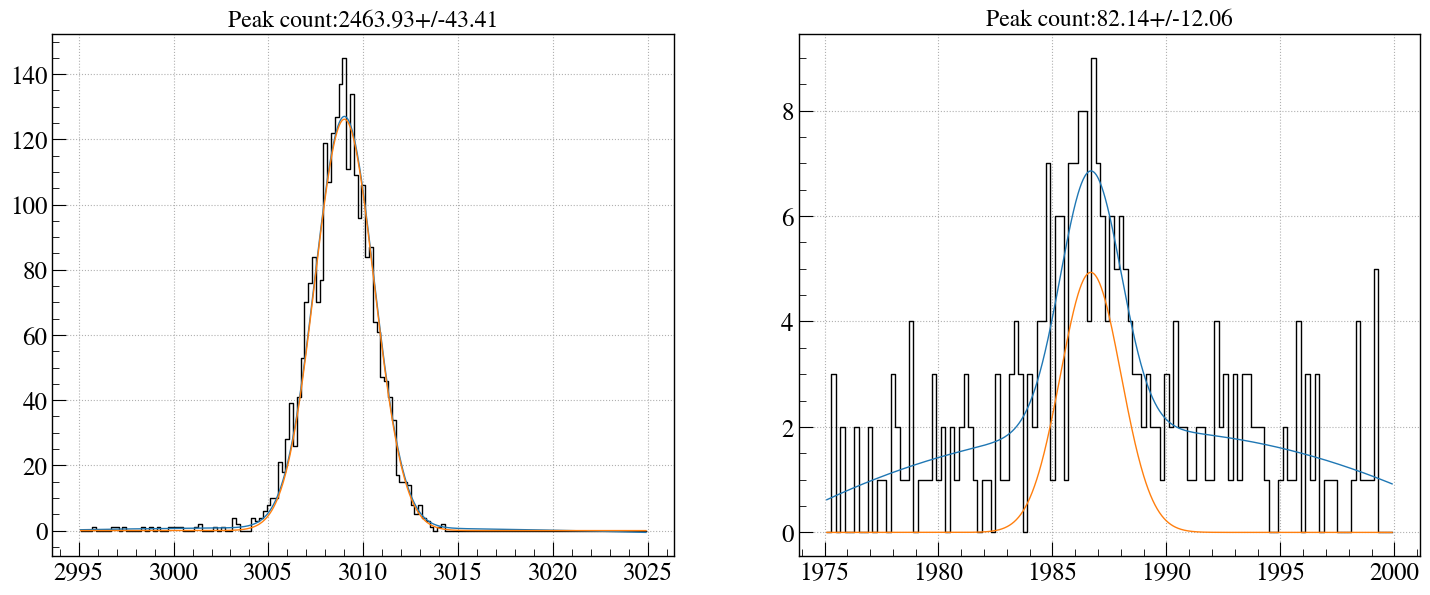

In [ ]:
peak = dep_peaks['1987']
peak = fep_peaks['3009']
fig, ax = plt.subplots(1,2, figsize=(16,6))
for i,peak in enumerate([fep_peaks['3009'], dep_peaks['1987']]):
    d = df[df['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2
    ax[i].plot(b_mids, h, ds='steps', lw=1, color='k')
    # get sum of hv where 1960<bv<1975
    print(get_peak_and_bkg_count(h, b))
    left_bkg = np.sum(h[np.where((b>peak['sidebands'][0][0]) & (b<peak['sidebands'][0][1]))])
    right_bkg = np.sum(h[np.where((b>peak['sidebands'][1][0]) & (b<peak['sidebands'][1][1]))])
    bkg_new = left_bkg + right_bkg
    print(bkg_new)

    
    fit_results = lu.fit_peak_binned_extra_basic(b_mids, h, axis=ax[i], lw=1)
    ax[i].set_title('Peak count:'+ str(round(fit_results['area'],2))+'+/-'+str(round(fit_results['area_err'],2)))

    if i==0:
        peak_count_3009_new = fit_results['area']
print('peak_count_new', peak_count_3009_new)

In [ ]:
dets_to_use

[1010809]

Text(0.5, 1.0, '3009 gamma sim [1010704]')

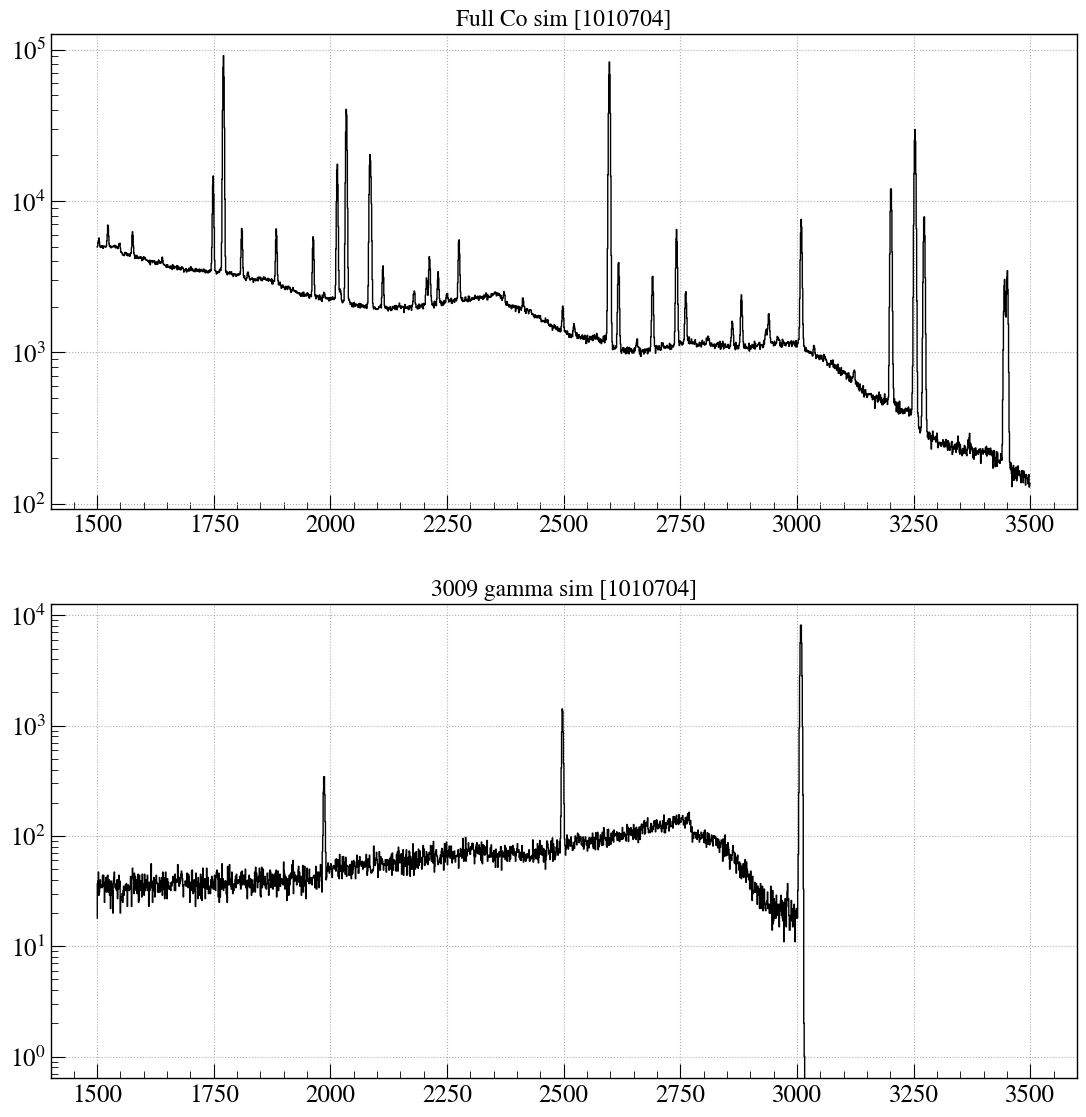

In [ ]:
dets_to_use = [1010704]
h,b,v = pgh.get_hist(df_vanc['energy'][df_vanc['mage_id'].isin(dets_to_use)], range=(1500, 3500), dx=1)
b_mids = (b[1:] + b[:-1])/2
fig, ax = plt.subplots(2,1, figsize=(12,12))
ax[0].plot(b_mids, h, ds='steps', lw=1, color='k')
ax[0].set_yscale('log')
ax[0].set_title('Full Co sim '+str(dets_to_use))

h,b,v = pgh.get_hist(df['energy'][df['mage_id'].isin(dets_to_use)], range=(1500, 3500), dx=1)
b_mids = (b[1:] + b[:-1])/2
ax[1].plot(b_mids, h, ds='steps', lw=1, color='k')
ax[1].set_yscale('log')
ax[1].set_title('3009 gamma sim '+str(dets_to_use))

In [ ]:
peak = dep_peaks['1987']

d_vanc = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
peak_count_1987_vanc, bkg_1987_vanc, _ = get_peak_and_bkg_count(h, b)
print('peak_count_1987_vanc', peak_count_1987_vanc, 'bkg_1987_vanc', bkg_1987_vanc)
d = df[df['mage_id'].isin(dets_to_use)]
h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
peak_count_1987_new, bkg_1987_new, _ = get_peak_and_bkg_count(h, b)
print('peak_count_1987_new', peak_count_1987_new, 'bkg_1987_new', bkg_1987_new)

old_to_new_1987_peak_count_ratio = peak_count_1987_new/peak_count_1987_vanc


peak_count_1987_vanc 799.8178460773386 bkg_1987_vanc 56800.18215392266
peak_count_1987_new 82.14499051274512 bkg_1987_new 192.85500948725488


In [ ]:
def get_scaled_spectrum(df_full_Co, primaries_full_Co, df_one_gamma, primaries_one_gamma, peak, dets_to_use):
    bkg_per_keV_per_primary_full_Co = get_bkg_per_keV_per_primary(df_full_Co, primaries_full_Co, dets_to_use, peak)
    d = df_one_gamma[df_one_gamma['mage_id'].isin(dets_to_use)]
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    

old_to_new_factor 8.479679807481908
primaries_new 1017561576.8978289
peak_count 799.8178460773386
B_sideband 37664.0
N_sideband 18527.0
tau 0.47058823529411764
rel_unc 0.06806230655345366
unc_vanc 0.06806230655345366
peak_count 30.34149410238941
B_sideband 373.1059115292039
N_sideband 381.58559133668587
tau 0.47058823529411764
rel_unc 0.03486229167467353
unc_new 0.03486229167467353


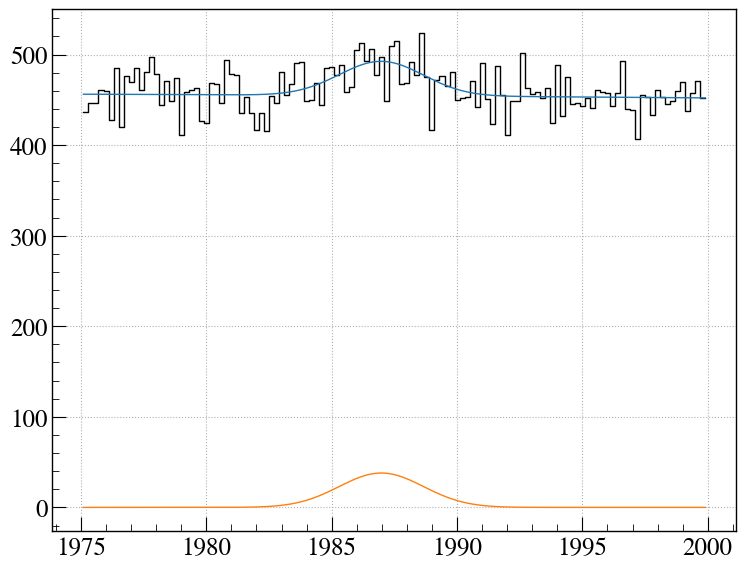

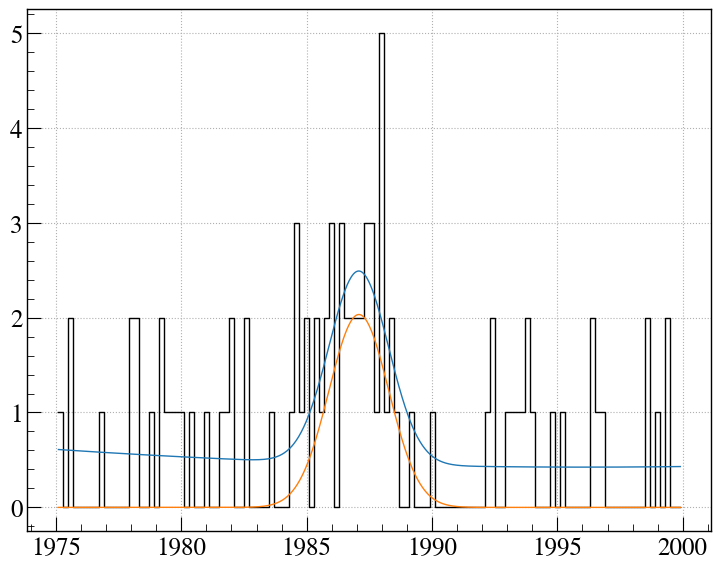

In [ ]:
peak = dep_peaks['1987']
primaries_vanc = 120e6
old_to_new_factor = peak_count_3009_new/peak_count_3009_vanc
print('old_to_new_factor', old_to_new_factor)
primaries_new = primaries_vanc*old_to_new_factor
print('primaries_new', primaries_new)


# sse survival probability
def get_survival_probability_uncertainty(d, peak, old_to_new_factor):
    h, b, v = pgh.get_hist(d['energy'], range=(peak['sidebands'][0][0], peak['sidebands'][1][1]), dx=0.2)
    b_mids = (b[1:] + b[:-1])/2

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(b_mids, h, ds='steps', lw=1, color='k')
    fit_results = lu.fit_peak_binned_extra_basic(b_mids, h, axis=ax, lw=1)
    peak_count = fit_results['area']
    print('peak_count', peak_count)

    # total events in d between end of first sideband and start of second sideband
    left_bkg = np.sum(h[np.where((b>peak['sidebands'][0][0]) & (b<peak['sidebands'][0][1]))])
    right_bkg = np.sum(h[np.where((b>peak['sidebands'][1][0]) & (b<peak['sidebands'][1][1]))])
    B = left_bkg + right_bkg
    B = B*old_to_new_factor
    print('B_sideband', B)
    N = np.sum(h[np.where((b>peak['sidebands'][0][1]) & (b<peak['sidebands'][1][0]))])
    N = N*old_to_new_factor
    print('N_sideband', N)
    tau = (peak['sidebands'][1][0]-peak['sidebands'][0][1])/(peak['sidebands'][1][1]-peak['sidebands'][1][0]+peak['sidebands'][0][1]-peak['sidebands'][0][0])
    print('tau',tau)
    epsilon = 0.9
    N_c = N*epsilon
    B_c = B*epsilon
    rel_unc_sqrd = (N+tau**2*B)/(N-tau*B)**2 + (N_c+tau**2*B_c)/(N_c-tau*B_c)**2 - 2*(N_c+tau**2*B_c)/(N_c-tau*B_c)/(N-tau*B)
    rel_unc = np.sqrt(rel_unc_sqrd)
    print('rel_unc', rel_unc)
    return rel_unc


d = df_vanc[df_vanc['mage_id'].isin(dets_to_use)]
unc_vanc = get_survival_probability_uncertainty(d, dep_peaks['1987'], old_to_new_factor=1.0)
print('unc_vanc', unc_vanc)
d = df[df['mage_id'].isin(dets_to_use)]
unc_new = get_survival_probability_uncertainty(d, dep_peaks['1987'], old_to_new_factor=old_to_new_factor)
print('unc_new', unc_new)


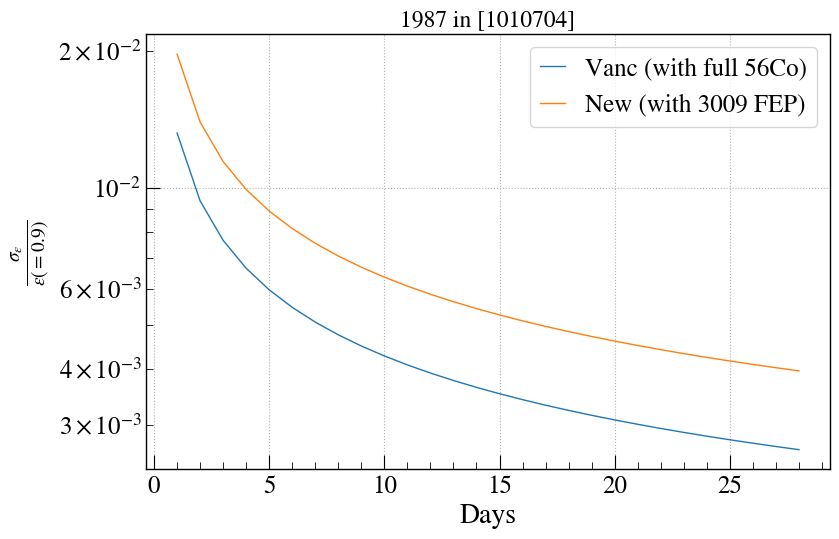

In [ ]:
def get_unc_over_time(primaries, unc, **kwargs):
    source_activity_uCi = 1 #uCi
    source_activity_Bq = source_activity_uCi*3.7e4 #Bq

    half_life = 77.236 # days
    half_life = half_life*24*60*60 # seconds
    decay_constant = np.log(2)/half_life # 1/s

    days_elapsed = np.arange(1, 29, 1)
    uncs = []
    for d in days_elapsed:
        N = source_activity_Bq/decay_constant*(1-np.exp(-decay_constant*d*86400))
        uncertainty = unc*np.sqrt(primaries/N)
        uncs.append(uncertainty)

    plt.plot(days_elapsed, uncs, lw=1, **kwargs)

    plt.yscale('log')
    # plt.xscale('log')
    plt.xlabel('Days')
    plt.ylabel(r'$\frac{\sigma_{\epsilon}}{\epsilon(=0.9)}$')
    plt.title('1987 in '+str(dets_to_use))

get_unc_over_time(primaries_vanc, unc_vanc, label='Vanc (with full 56Co)')
get_unc_over_time(primaries_new, unc_new, label='New (with 3009 FEP)')
plt.legend()